In [13]:
import chess
import sqlite3
import numpy as np
def board_intersection_metric(fen1, fen2):
    board1: chess.Board = chess.Board(fen1)
    board2: chess.Board = chess.Board(fen2)

    if not board1.turn:
        board1 = board1.mirror()

    if not board2.turn:
        board2 = board2.mirror()

    sum = 0
    ## Check white pieces
    for piece in chess.PIECE_TYPES:
        overlap =  board1.pieces_mask(piece, True) & board2.pieces_mask(piece, True)
        sum += bin(overlap).count("1")
    # Check black pieces
    for piece in chess.PIECE_TYPES:
        overlap = board1.pieces_mask(piece, False) & board2.pieces_mask(piece, False)
        sum += bin(overlap).count("1")
    return sum

def board_intersection(fen1, fen2):
    board1: chess.Board = chess.Board(fen1)
    board2: chess.Board = chess.Board(fen2)

    if not board1.turn:
        board1 = board1.mirror()

    if not board2.turn:
        board2 = board2.mirror()

    intersection_dict = {}
    for piece in chess.PIECE_TYPES:
        white_overlap =  board1.pieces_mask(piece, True) & board2.pieces_mask(piece, True)
        intersection_dict[(piece, True)] = bitboard_to_bool_array(white_overlap)

        black_overlap = board1.pieces_mask(piece, False) & board2.pieces_mask(piece, False)
        intersection_dict[(piece, False)] = bitboard_to_bool_array(black_overlap)

    return intersection_dict

def bitboard_to_bool_array(bitboard: int) -> np.ndarray:
    """Convert a 64-bit bitboard to an 8x8 NumPy boolean array (rank 8 to 1, file A to H)."""
    flat = np.array([(bitboard >> i) & 1 for i in range(64)], dtype=bool)
    return flat.reshape((8, 8))[::-1]  # Flip vertically to get rank 8 at the top


table_name = "RUN_04012214JumpReluCoordinateTrainer"

def get_db_conn():
    conn = sqlite3.connect("/home/zachary/PycharmProjects/SparseMate/SparseMate.sqlite")
    return conn

query = f"""SELECT fen, sq, feature, value from {table_name} where feature = 8643;"""

connection  = get_db_conn()

results = connection.cursor().execute(query).fetchall()

fen_set = set()

for row in results:
    fen = row[0]
    fen_set.add(fen)

piece_intersection_distribution = {}

for piece in chess.PIECE_TYPES:
    piece_intersection_distribution[(piece, True)] = np.zeros(shape=(8,8))
    piece_intersection_distribution[(piece, False)] = np.zeros(shape=(8,8))
# Copy the set to avoid modifying it while iterating
fen_set_copy = fen_set.copy()

i = 0
for fen in fen_set_copy:
    fen_set.remove(fen)  # Safe removal now
    for compare_fen in fen_set:
        intersection = board_intersection(fen, compare_fen)
        i += 1
        for key, value in intersection.items():
            piece_intersection_distribution[key] += value > 0

pieces = ["PAWN", "KNIGHT", "BISHOP", "ROOK", "QUEEN", "KING"]



In [14]:
import matplotlib.pyplot as plt


In [10]:
print(chess.Board().mirror())

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


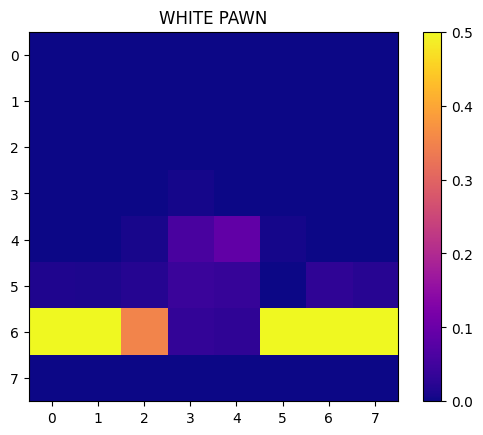

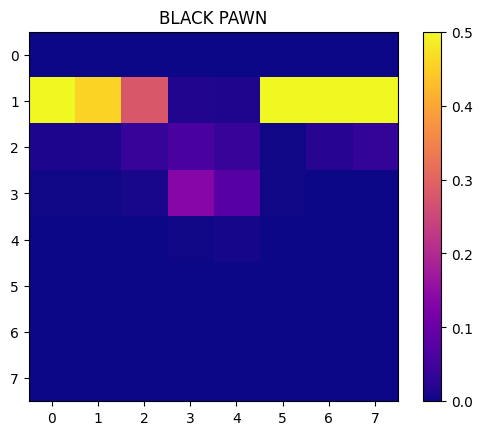

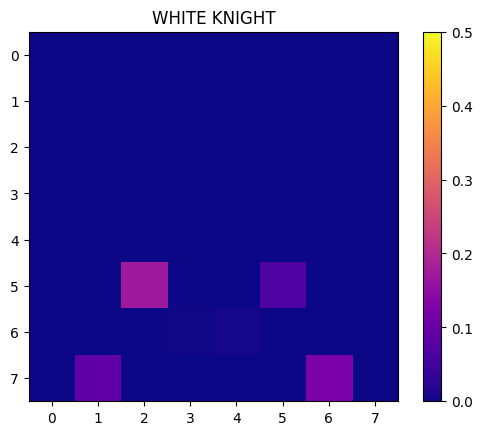

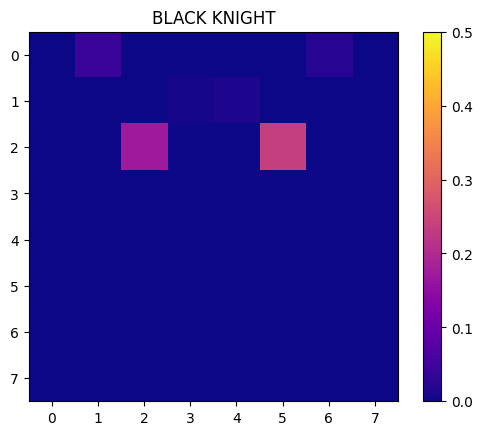

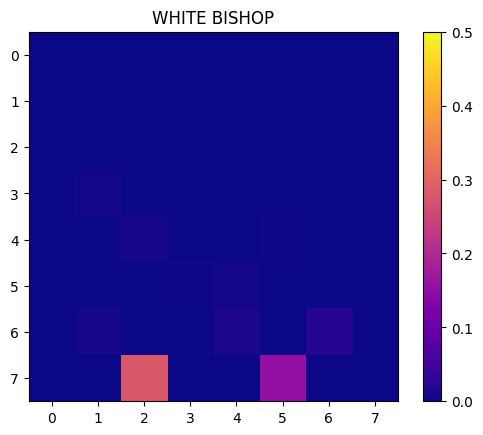

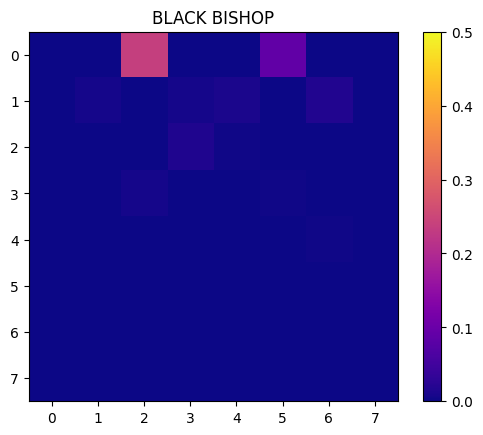

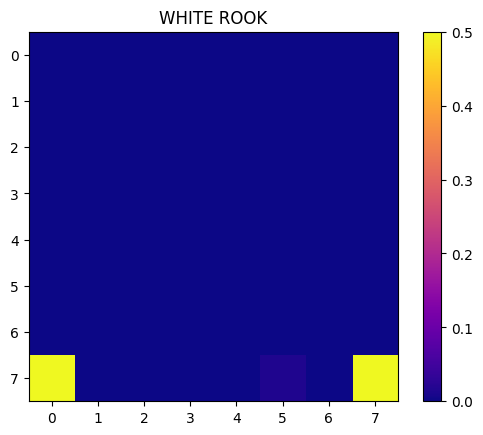

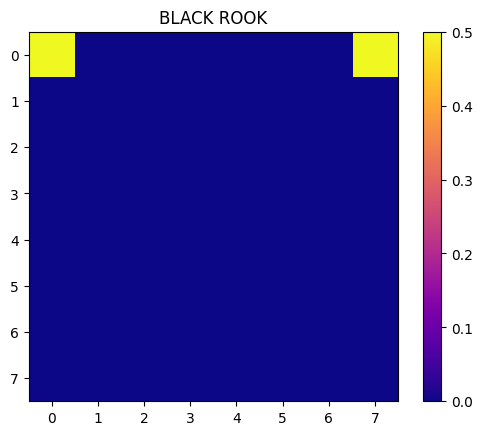

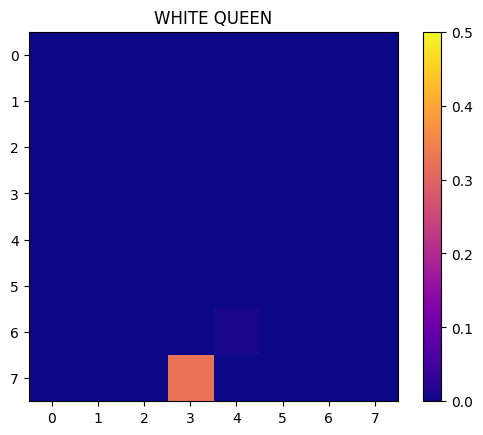

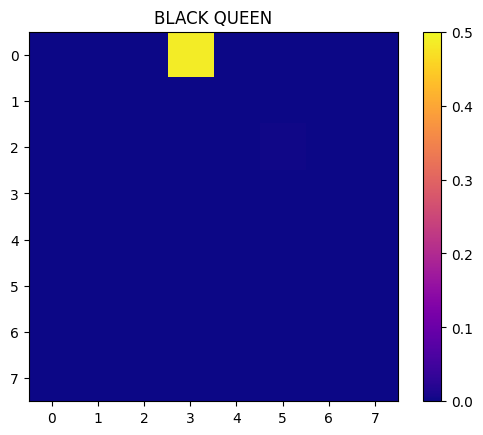

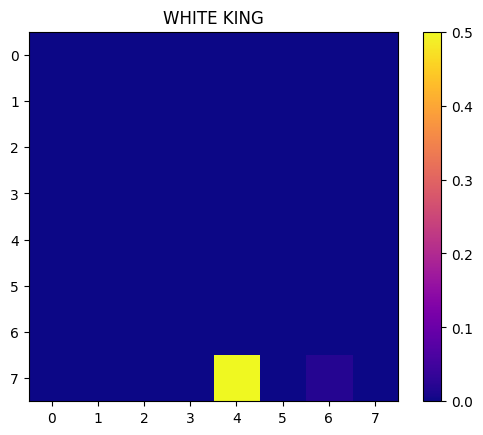

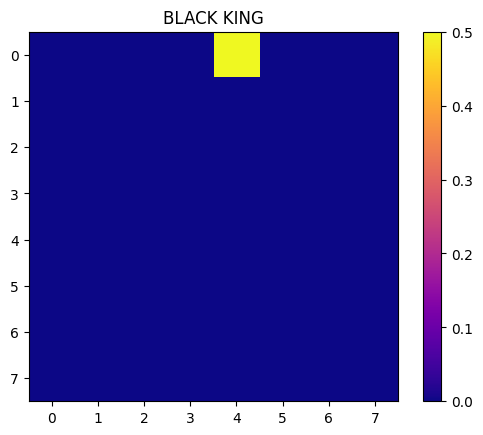

In [16]:
pieces = ["PAWN", "KNIGHT", "BISHOP", "ROOK", "QUEEN", "KING"]

vmax = 0.5

for j in range(1,7):
    plt.imshow(piece_intersection_distribution[(j,True)]/i, cmap = 'plasma', vmin = 0, vmax = vmax)
    plt.title("WHITE " + pieces[j - 1])
    plt.colorbar()
    plt.show()

    plt.imshow(piece_intersection_distribution[(j,False)]/i, cmap = 'plasma', vmin = 0, vmax = vmax)
    plt.title("BLACK " + pieces[j - 1])
    plt.colorbar()
    plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from model_tools.truncated_leela import TruncatedModel
from torch.utils.data import DataLoader
from feature_evaluator import BoardActivationBuffer
from dictionary_learning.dictionary import GOGS, DimensionReduction
from my_datasets import DatasetsAPI

# Dataset and model setup
puzzle_dataset = DatasetsAPI.get("PuzzleDataset", "/home/zachary/PycharmProjects/SparseMate/my_datasets/datasets_data/lichess_puzzles/lichess_db_puzzle.csv")
onnx_model_path = "/home/zachary/PycharmProjects/SparseMate/lc0.onnx"
model: GOGS = GOGS.from_pretrained("/home/zachary/PycharmProjects/SparseMate/SAE_Models/0424_16:47_GOGS/ae.pt")
dataloader = DataLoader(puzzle_dataset, batch_size=None, batch_sampler=None)
submodule: TruncatedModel = TruncatedModel(onnx_model_path, layer=2)

activation_buffer = BoardActivationBuffer(
    data=iter(dataloader),
    submodule=submodule,
    d_submodule=768,
    device="cuda",
    size=100
)

single_layer = DimensionReduction(model.basis_set)

# Buffers to store norms
layer_norms = [[] for _ in range(7)]  # 0 = input, 1-6 = layer outputs
diff_norms = [[] for _ in range(6)]   # 0 = diff between layer 0 and 1, etc.

i = 0
with torch.no_grad():
    for _, activation_batch in activation_buffer:
        current = activation_batch
        layer_norms[0].append(torch.norm(current, dim=1))

        for layer_index in range(6):
            next_ = single_layer(current)
            layer_norms[layer_index + 1].append(torch.norm(next_, dim=1))
            diff_norms[layer_index].append(torch.norm(current - next_, dim=1))
            current = next_

        i += 1
        if i > 40:
            break

# Concatenate all batches
layer_norms = [torch.cat(norms).cpu().numpy() for norms in layer_norms]
diff_norms = [torch.cat(norms).cpu().numpy() for norms in diff_norms]

# Plotting
plt.figure(figsize=(12, 10))

# Plot all layer norms
for i, norms in enumerate(layer_norms):
    plt.hist(norms, bins=50, alpha=0.5, label=f'Layer {i} Norms')

plt.xlabel('L2 Norm')
plt.ylabel('Frequency')
plt.title('Distribution of Vector Norms Across 6 Layers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot diffs
plt.figure(figsize=(12, 10))
for i, norms in enumerate(diff_norms):
    plt.hist(norms, bins=50, alpha=0.5, label=f'Diff Norms Layer {i} → {i+1}')

plt.xlabel('L2 Norm of Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Norm Differences Between Layers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


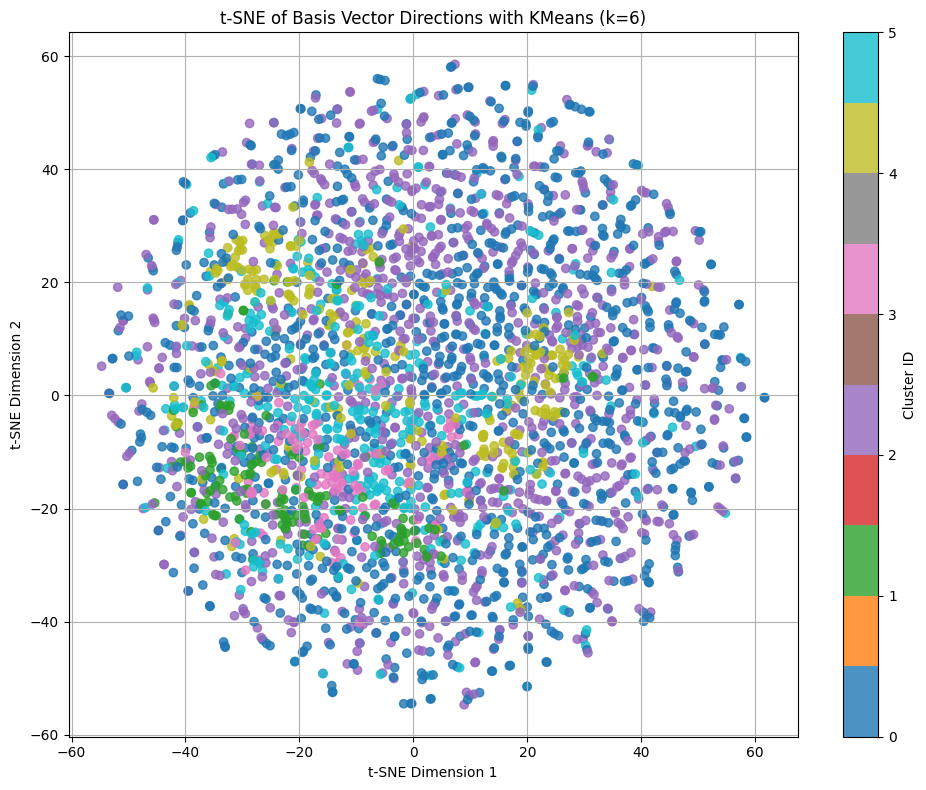

Clustering Summary Statistics:
  Inertia (Sum of Squared Distances):       3018.38
  Silhouette Score ([-1, 1]):               0.001
  Calinski-Harabasz Index (Higher=Better):  9.94
  Davies-Bouldin Index (Lower=Better):      12.644


In [7]:
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Extract basis set as NumPy array
basis_set = model.basis_set.detach().cpu().numpy()  # shape: (num_vectors, dim)

# Choose number of clusters
n_clusters = 6

# Cluster with KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(basis_set)

# Use t-SNE for 2D projection (you can adjust perplexity if needed)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
basis_tsne = tsne.fit_transform(basis_set)

# Plot the t-SNE projection with cluster labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    basis_tsne[:, 0],
    basis_tsne[:, 1],
    c=cluster_labels,
    cmap='tab10',
    alpha=0.8
)
plt.title(f't-SNE of Basis Vector Directions with KMeans (k={n_clusters})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.tight_layout()
plt.show()
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Compute metrics
inertia = kmeans.inertia_
sil_score = silhouette_score(basis_set, cluster_labels)
ch_score = calinski_harabasz_score(basis_set, cluster_labels)
db_score = davies_bouldin_score(basis_set, cluster_labels)

# Print summary
print("Clustering Summary Statistics:")
print(f"  Inertia (Sum of Squared Distances):       {inertia:.2f}")
print(f"  Silhouette Score ([-1, 1]):               {sil_score:.3f}")
print(f"  Calinski-Harabasz Index (Higher=Better):  {ch_score:.2f}")
print(f"  Davies-Bouldin Index (Lower=Better):      {db_score:.3f}")


In [ ]:
import torch
import matplotlib.pyplot as plt
from model_tools.truncated_leela import TruncatedModel
from torch.utils.data import DataLoader
from feature_evaluator import BoardActivationBuffer
from dictionary_learning.dictionary import GOGS, DimensionReduction
from my_datasets import DatasetsAPI

# Dataset and model setup
puzzle_dataset = DatasetsAPI.get("PuzzleDataset", "/home/zachary/PycharmProjects/SparseMate/my_datasets/datasets_data/lichess_puzzles/lichess_db_puzzle.csv")
onnx_model_path = "/home/zachary/PycharmProjects/SparseMate/lc0.onnx"
model: GOGS = GOGS.from_pretrained("/home/zachary/PycharmProjects/SparseMate/SAE_Models/0412_16:24_GOGSTrainer/ae.pt")
dataloader = DataLoader(puzzle_dataset, batch_size=None, batch_sampler=None)
submodule: TruncatedModel = TruncatedModel(onnx_model_path, layer=2)

activation_buffer = BoardActivationBuffer(
    data=iter(dataloader),
    submodule=submodule,
    d_submodule=768,
    device="cuda",
    size=100
)

single_layer = DimensionReduction(model.basis_set)

# Buffers to store norms
layer_norms = [[] for _ in range(7)]  # 0 = input, 1-6 = layer outputs
diff_norms = [[] for _ in range(6)]   # 0 = diff between layer 0 and 1, etc.

i = 0
with torch.no_grad():
    for _, activation_batch in activation_buffer:
        current = activation_batch
        layer_norms[0].append(torch.norm(current, dim=1))

        for layer_index in range(20):
            next_ = single_layer(current)
            layer_norms[layer_index + 1].append(torch.norm(next_, dim=1))
            diff_norms[layer_index].append(torch.norm(current - next_, dim=1))
            current = next_

        i += 1
        if i > 40:
            break


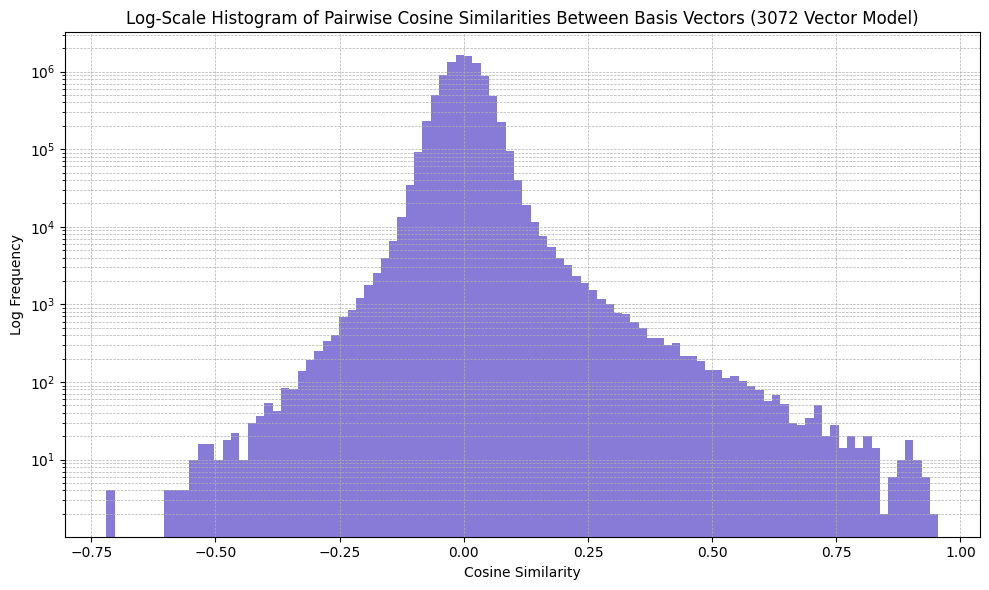

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure normalization (precautionary)
basis = model.basis_set.detach().cpu()
basis = basis / basis.norm(dim=1, keepdim=True)

# Cosine similarity matrix via dot product
cosine_sim_matrix = torch.matmul(basis, basis.T)

# Mask out self-similarities
num_vectors = cosine_sim_matrix.shape[0]
mask = ~torch.eye(num_vectors, dtype=bool)
cosine_sims = cosine_sim_matrix[mask].numpy()

# Plot histogram with log-scale y-axis
plt.figure(figsize=(10, 6))
plt.hist(cosine_sims, bins=100, color='slateblue', alpha=0.8)
plt.yscale('log')
plt.title("Log-Scale Histogram of Pairwise Cosine Similarities Between Basis Vectors (3072 Vector Model)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Log Frequency")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


/home/zachary/PycharmProjects/SparseMate/dictionary_learning/src/dictionary_learning/dictionary.py:601: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(pat

GOGS initialized on None, with dtype=torch.float32


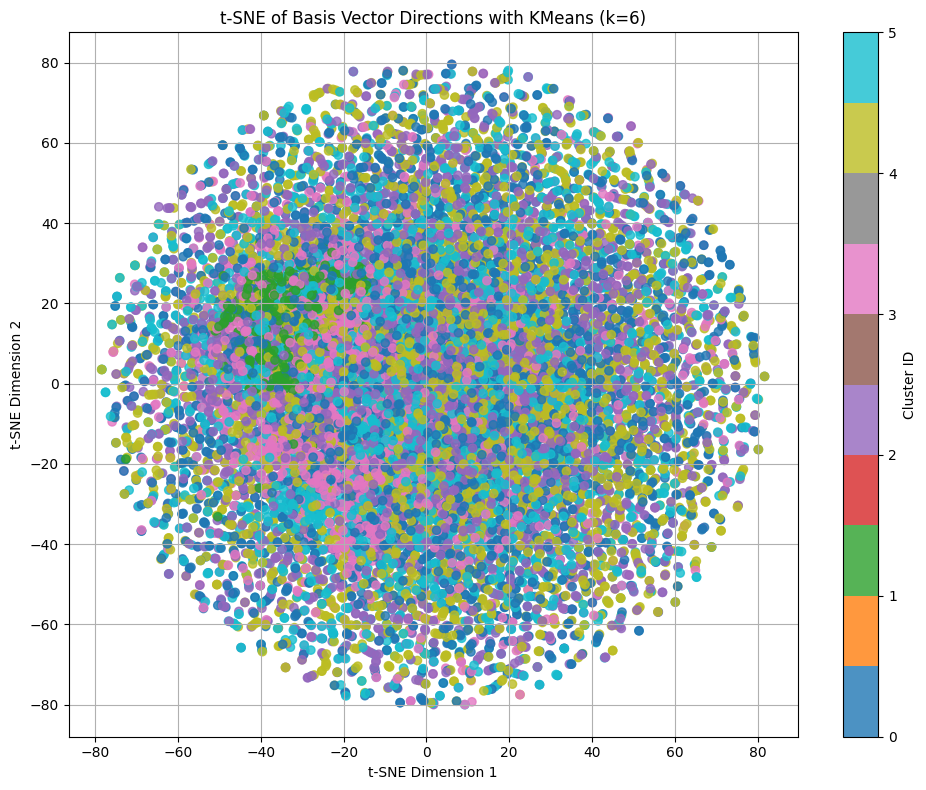

Clustering Summary Statistics:
  Inertia (Sum of Squared Distances):       12208.03
  Silhouette Score ([-1, 1]):               0.000
  Calinski-Harabasz Index (Higher=Better):  15.17
  Davies-Bouldin Index (Lower=Better):      18.155


In [10]:
model2: GOGS = GOGS.from_pretrained("/home/zachary/PycharmProjects/SparseMate/SAE_Models/0412_17:22_GOGSTrainer/ae.pt")
basis_set2 = model2.basis_set.detach().cpu().numpy()
# Choose number of clusters
n_clusters = 6

# Cluster with KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(basis_set2)

# Use t-SNE for 2D projection (you can adjust perplexity if needed)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
basis_tsne = tsne.fit_transform(basis_set2)

# Plot the t-SNE projection with cluster labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    basis_tsne[:, 0],
    basis_tsne[:, 1],
    c=cluster_labels,
    cmap='tab10',
    alpha=0.8
)
plt.title(f't-SNE of Basis Vector Directions with KMeans (k={n_clusters})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.tight_layout()
plt.show()
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Compute metrics
inertia = kmeans.inertia_
sil_score = silhouette_score(basis_set2, cluster_labels)
ch_score = calinski_harabasz_score(basis_set2, cluster_labels)
db_score = davies_bouldin_score(basis_set2, cluster_labels)

# Print summary
print("Clustering Summary Statistics:")
print(f"  Inertia (Sum of Squared Distances):       {inertia:.2f}")
print(f"  Silhouette Score ([-1, 1]):               {sil_score:.3f}")
print(f"  Calinski-Harabasz Index (Higher=Better):  {ch_score:.2f}")
print(f"  Davies-Bouldin Index (Lower=Better):      {db_score:.3f}")



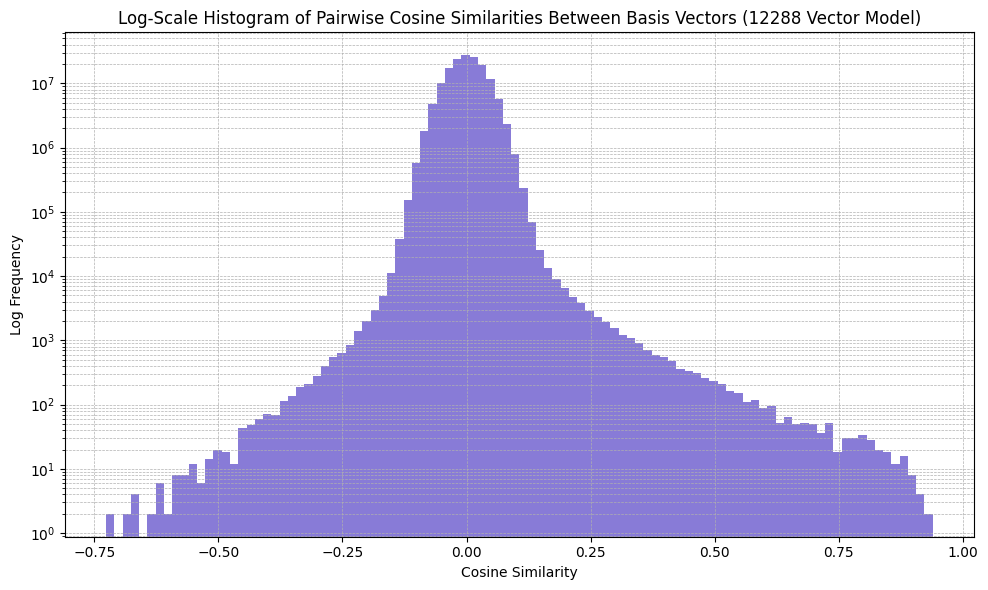

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure normalization (precautionary)
basis = model2.basis_set.detach().cpu()
basis = basis / basis.norm(dim=1, keepdim=True)

# Cosine similarity matrix via dot product
cosine_sim_matrix = torch.matmul(basis, basis.T)

# Mask out self-similarities
num_vectors = cosine_sim_matrix.shape[0]
mask = ~torch.eye(num_vectors, dtype=bool)
cosine_sims = cosine_sim_matrix[mask].numpy()

# Plot histogram with log-scale y-axis
plt.figure(figsize=(10, 6))
plt.hist(cosine_sims, bins=100, color='slateblue', alpha=0.8)
plt.yscale('log')
plt.title("Log-Scale Histogram of Pairwise Cosine Similarities Between Basis Vectors (12288 Vector Model)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Log Frequency")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


GOGS initialized on None, with dtype=torch.float32


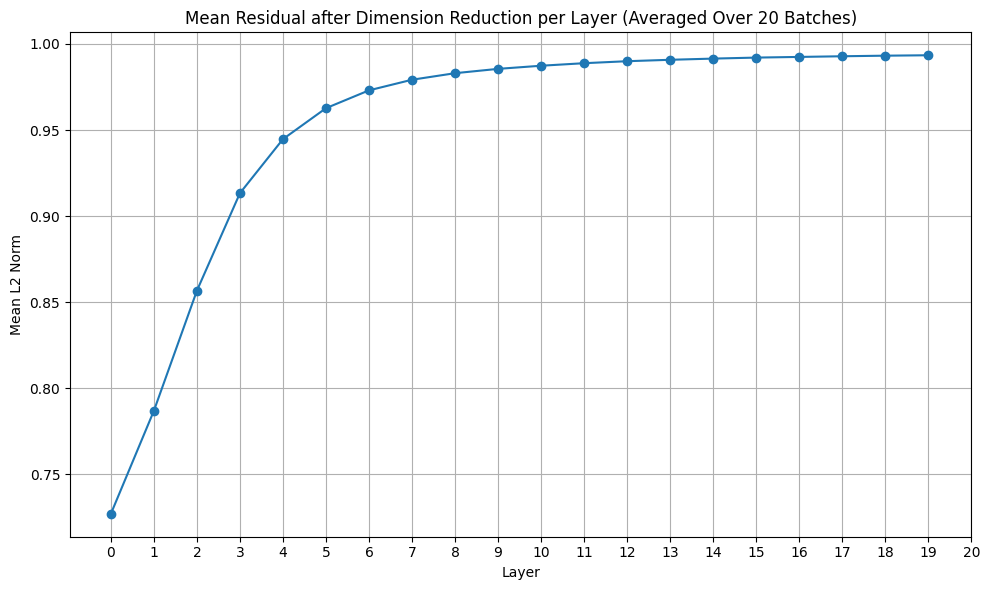

0.9183674067258835


In [9]:
import torch
import matplotlib.pyplot as plt
from model_tools.truncated_leela import TruncatedModel
from torch.utils.data import DataLoader
from feature_evaluator import BoardActivationBuffer
from dictionary_learning.dictionary import GOGS, DimensionReduction
from my_datasets import DatasetsAPI
import numpy as np

# Dataset and model setup
puzzle_dataset = DatasetsAPI.get("PuzzleDataset", "/home/zachary/PycharmProjects/SparseMate/my_datasets/datasets_data/lichess_puzzles/lichess_db_puzzle.csv")
onnx_model_path = "/home/zachary/PycharmProjects/SparseMate/lc0.onnx"
model2: GOGS = GOGS.from_pretrained("/home/zachary/PycharmProjects/SparseMate/SAE_Models/0413_16:34_GOGSTrainer/ae.pt")
dataloader = DataLoader(puzzle_dataset, batch_size=None, batch_sampler=None)
submodule: TruncatedModel = TruncatedModel(onnx_model_path, layer=2)

activation_buffer = BoardActivationBuffer(
    data=iter(dataloader),
    submodule=submodule,
    d_submodule=768,
    device="cuda",
    size=100
)

single_layer = DimensionReduction(model2.basis_set)

num_layers = 20

# Buffers to store accumulated means
layer_norm_sums = [0.0 for _ in range(num_layers+1)]
diff_norm_sums = [0.0 for _ in range(num_layers)]
num_batches = 0


with torch.no_grad():
    for _, activation_batch in activation_buffer:
        current = activation_batch
        layer_norm_sums[0] += torch.norm(current, dim=1).mean().item()

        for layer_index in range(num_layers):
            next_ = single_layer(current)
            layer_norm_sums[layer_index + 1] += torch.norm(next_, dim=1).mean().item()
            diff_norm_sums[layer_index] += torch.norm(current - next_, dim=1).mean().item()
            current = next_

        num_batches += 1
        if num_batches >= 20:
            break

# Final mean norms
mean_layer_norms = [total / num_batches for total in layer_norm_sums]
mean_diff_norms = [total / num_batches for total in diff_norm_sums]
mean_layer_norms2 = mean_layer_norms
# Plotting mean L2 norm per layer
plt.figure(figsize=(10, 6))
plt.plot(range(num_layers ), np.divide(mean_layer_norms[1:], mean_layer_norms[0:-1]), marker='o')
plt.xlabel('Layer')
plt.ylabel('Mean L2 Norm')
plt.title('Mean Residual after Dimension Reduction per Layer (Averaged Over 20 Batches)')
plt.grid(True)
plt.xticks(range(num_layers + 1))
plt.tight_layout()
plt.show()

print(mean_layer_norms[20])


GOGS initialized on None, with dtype=torch.float32


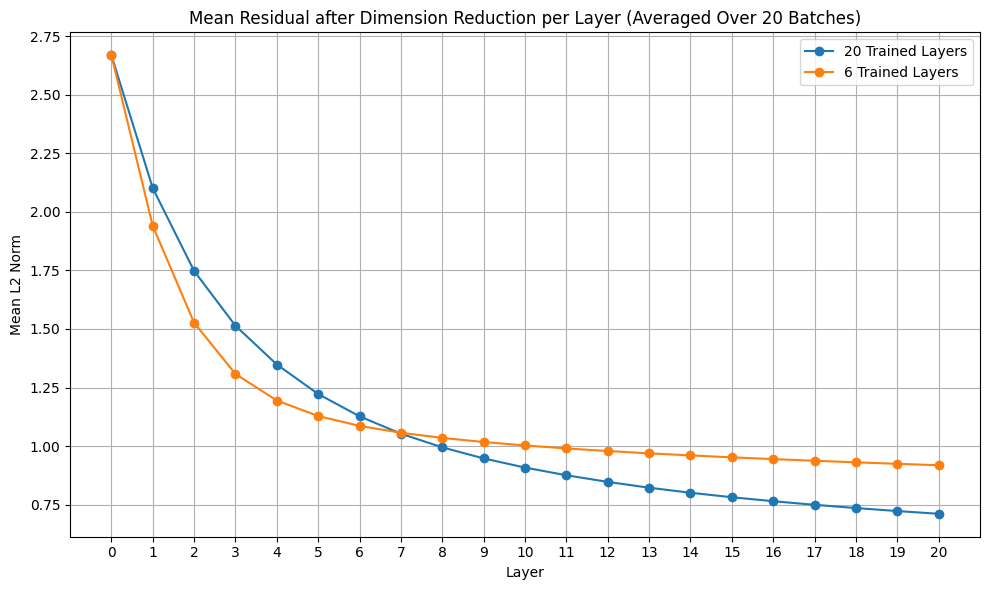

In [11]:
import torch
import matplotlib.pyplot as plt
from model_tools.truncated_leela import TruncatedModel
from torch.utils.data import DataLoader
from feature_evaluator import BoardActivationBuffer
from dictionary_learning.dictionary import GOGS, DimensionReduction
from my_datasets import DatasetsAPI

# Dataset and model setup
puzzle_dataset = DatasetsAPI.get("PuzzleDataset", "/home/zachary/PycharmProjects/SparseMate/my_datasets/datasets_data/lichess_puzzles/lichess_db_puzzle.csv")
onnx_model_path = "/home/zachary/PycharmProjects/SparseMate/lc0.onnx"
model: GOGS = GOGS.from_pretrained("/home/zachary/PycharmProjects/SparseMate/SAE_Models/0413_16:45_GOGSTrainer/ae.pt")
dataloader = DataLoader(puzzle_dataset, batch_size=None, batch_sampler=None)
submodule: TruncatedModel = TruncatedModel(onnx_model_path, layer=2)

activation_buffer = BoardActivationBuffer(
    data=iter(dataloader),
    submodule=submodule,
    d_submodule=768,
    device="cuda",
    size=100
)

single_layer = DimensionReduction(model.basis_set)

num_layers = 20

# Buffers to store accumulated means
layer_norm_sums = [0.0 for _ in range(num_layers+1)]
diff_norm_sums = [0.0 for _ in range(num_layers)]
num_batches = 0


with torch.no_grad():
    for _, activation_batch in activation_buffer:
        current = activation_batch
        layer_norm_sums[0] += torch.norm(current, dim=1).mean().item()

        for layer_index in range(num_layers):
            next_ = single_layer(current)
            layer_norm_sums[layer_index + 1] += torch.norm(next_, dim=1).mean().item()
            diff_norm_sums[layer_index] += torch.norm(current - next_, dim=1).mean().item()
            current = next_

        num_batches += 1
        if num_batches >= 20:
            break

# Final mean norms
mean_layer_norms = [total / num_batches for total in layer_norm_sums]
mean_diff_norms = [total / num_batches for total in diff_norm_sums]

plt.figure(figsize=(10, 6))
plt.plot(range(num_layers + 1), mean_layer_norms, marker='o', label='20 Trained Layers')
plt.plot(range(num_layers + 1), mean_layer_norms2, marker='o', label='6 Trained Layers')
plt.xlabel('Layer')
plt.ylabel('Mean L2 Norm')
plt.title('Mean Residual after Dimension Reduction per Layer (Averaged Over 20 Batches)')
plt.grid(True)
plt.xticks(range(num_layers + 1))
plt.legend()
plt.tight_layout()
plt.show()





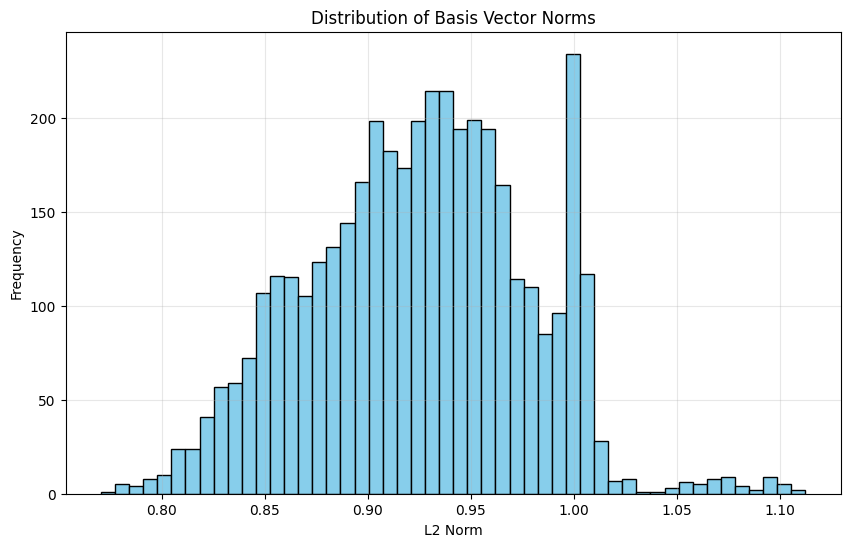

Mean norm: 0.9251
Std norm: 0.0535
Min norm: 0.7705
Max norm: 1.1124


In [1]:
import numpy as np
from dictionary_learning.dictionary import GOGS
import matplotlib.pyplot as plt
model: GOGS = GOGS.from_pretrained("/home/zachary/PycharmProjects/SparseMate/SAE_Models/0424_17:53_GOGS/ae.pt")

basis: np.ndarray = model.basis_set.detach().cpu().numpy()
norms = np.linalg.norm(basis, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(norms, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Basis Vector Norms')
plt.xlabel('L2 Norm')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean norm: {norms.mean():.4f}")
print(f"Std norm: {norms.std():.4f}")
print(f"Min norm: {norms.min():.4f}")
print(f"Max norm: {norms.max():.4f}")